In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "data/"
sales = pd.read_csv(f"{DATA_PATH}/sales_train.csv")
test  = pd.read_csv(f"{DATA_PATH}/test.csv")
items = pd.read_csv(f"{DATA_PATH}/items.csv")
shops = pd.read_csv(f"{DATA_PATH}/shops.csv")
cats  = pd.read_csv(f"{DATA_PATH}/item_categories.csv")

print("sales:", sales.shape)
print("test :", test.shape)
print("items:", items.shape)
print("shops:", shops.shape)
print("cats :", cats.shape)

sales.head()


sales: (2935849, 6)
test : (214200, 3)
items: (22170, 3)
shops: (60, 2)
cats : (84, 2)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
sales["date"] = pd.to_datetime(sales["date"], format="%d.%m.%Y")
sales[["date", "date_block_num"]].describe()


,date,date_block_num
count,2935849,2.935849e+06
mean,2014-04-03 05:44:34.970681344,1.456991e+01
min,2013-01-01 00:00:00,0.000000e+00
25%,2013-08-01 00:00:00,7.000000e+00
50%,2014-03-04 00:00:00,1.400000e+01
75%,2014-12-05 00:00:00,2.300000e+01
max,2015-10-31 00:00:00,3.300000e+01
std,NaN,9.422988e+00


In [5]:
print("Ventas negativas (item_cnt_day < 0):", (sales["item_cnt_day"] < 0).sum())
print("Precios <= 0:", (sales["item_price"] <= 0).sum())

sales[["item_price", "item_cnt_day"]].describe(percentiles=[.5,.9,.95,.99])

Ventas negativas (item_cnt_day < 0): 7356
Precios <= 0: 1


,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06
mean,8.908532e+02,1.242641e+00
std,1.729800e+03,2.618834e+00
min,-1.000000e+00,-2.200000e+01
50%,3.990000e+02,1.000000e+00
90%,1.999000e+03,2.000000e+00
95%,2.690000e+03,2.000000e+00
99%,5.999000e+03,5.000000e+00
max,3.079800e+05,2.169000e+03


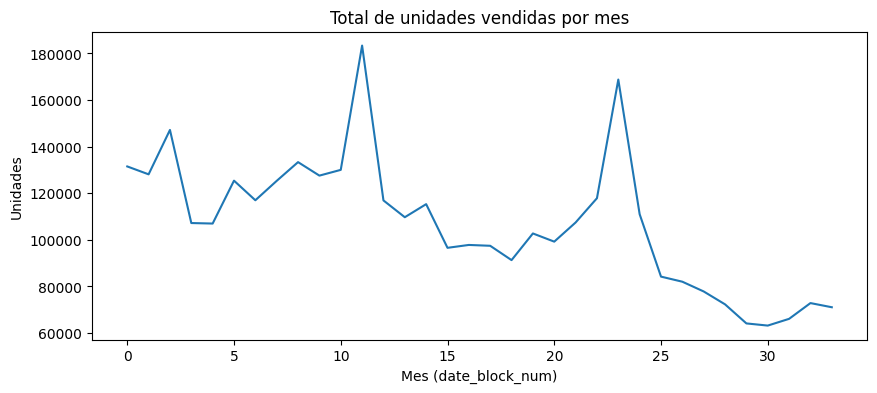

,date_block_num,total_units
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0


In [6]:
monthly = (sales
           .groupby("date_block_num", as_index=False)["item_cnt_day"]
           .sum()
           .rename(columns={"item_cnt_day": "total_units"}))

plt.figure(figsize=(10,4))
plt.plot(monthly["date_block_num"], monthly["total_units"])
plt.title("Total de unidades vendidas por mes")
plt.xlabel("Mes (date_block_num)")
plt.ylabel("Unidades")
plt.show()

monthly.head()



In [8]:
monthly_sales = (sales
    .groupby(["date_block_num", "shop_id", "item_id"], as_index=False)
    .agg({"item_cnt_day": "sum"})
    .rename(columns={"item_cnt_day": "item_cnt_month"})
)

print("Monthly sales shape:", monthly_sales.shape)
monthly_sales.head()


Monthly sales shape: (1609124, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [9]:
monthly_sales["item_cnt_month_clipped"] = monthly_sales["item_cnt_month"].clip(0, 20)

monthly_sales[["item_cnt_month", "item_cnt_month_clipped"]].describe(percentiles=[.5,.9,.95,.99])


,item_cnt_month,item_cnt_month_clipped
count,1.609124e+06,1.609124e+06
mean,2.267200e+00,2.022806e+00
std,8.649882e+00,2.577964e+00
min,-2.200000e+01,0.000000e+00
50%,1.000000e+00,1.000000e+00
90%,4.000000e+00,4.000000e+00
95%,6.000000e+00,6.000000e+00
99%,1.700000e+01,1.700000e+01
max,2.253000e+03,2.000000e+01


In [10]:
zero_share = (monthly_sales["item_cnt_month"] == 0).mean()
print(f"% de combinaciones tienda-producto-mes con 0 ventas: {zero_share:.2%}")

monthly_sales["item_cnt_month"].value_counts().head(10)


% de combinaciones tienda-producto-mes con 0 ventas: 0.16%


item_cnt_month
1.0     1058825
2.0      265502
3.0      103227
4.0       53327
5.0       31974
6.0       20731
7.0       14060
8.0       10430
9.0        7540
10.0       6013
Name: count, dtype: int64

In [11]:
# Todas las tiendas y productos que existen en cada mes
grid = []

for block_num in monthly_sales["date_block_num"].unique():
    shops_in_month = sales.loc[sales["date_block_num"] == block_num, "shop_id"].unique()
    items_in_month = sales.loc[sales["date_block_num"] == block_num, "item_id"].unique()
    grid.append(
        pd.MultiIndex.from_product(
            [ [block_num], shops_in_month, items_in_month ],
            names=["date_block_num", "shop_id", "item_id"]
        ).to_frame(index=False)
    )

grid = pd.concat(grid, axis=0)

print("Grid shape:", grid.shape)
grid.head()


Grid shape: (10913850, 3)


,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [12]:
monthly_full = (
    grid
    .merge(monthly_sales, 
           on=["date_block_num", "shop_id", "item_id"], 
           how="left")
)

monthly_full["item_cnt_month"] = monthly_full["item_cnt_month"].fillna(0)
monthly_full["item_cnt_month_clipped"] = monthly_full["item_cnt_month_clipped"].fillna(0)

print("Monthly FULL shape:", monthly_full.shape)
monthly_full.head()



Monthly FULL shape: (10913850, 5)


,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_clipped
0,0,59,22154,1.0,1.0
1,0,59,2552,0.0,0.0
2,0,59,2554,0.0,0.0
3,0,59,2555,0.0,0.0
4,0,59,2564,0.0,0.0


In [13]:
zero_share_full = (monthly_full["item_cnt_month"] == 0).mean()
print(f"% REAL de combinaciones tienda-producto-mes con 0 ventas: {zero_share_full:.2%}")

monthly_full["item_cnt_month"].value_counts().head(10)


% REAL de combinaciones tienda-producto-mes con 0 ventas: 85.28%


item_cnt_month
0.0    9307309
1.0    1058825
2.0     265502
3.0     103227
4.0      53327
5.0      31974
6.0      20731
7.0      14060
8.0      10430
9.0       7540
Name: count, dtype: int64

In [16]:
import os
os.makedirs("data/processed", exist_ok=True)


In [18]:
monthly_full.to_parquet("data/processed/monthly_full.parquet", index=False)
